# MultiplEYE preprocessing

In [1]:
from pathlib import Path

data_dir = Path("../data/pilot-hr-1-zh")
stim_dir = Path("../data/stimuli_MultiplEYE_HR_CH_Zurich_1_2025")
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)


## EDF to ASC

Use the `edf2asc` binary from the [EyeLink Developers Kit](https://www.sr-research.com/support/thread-13.html) to convert EDF files to ASC files.

Notes:
- We probably can't distribute the binary due to licensing issues. (But we might be able to distribute a Docker image?)
- There is already an [issue](https://github.com/aeye-lab/pymovements/issues/509) to integrate this into `pymovements`.
- The `-input` option is unnecessary, but currently required by `parse_eyelink()` in `pymovements`.

In [12]:
import subprocess

edf = data_dir / "ch1hr007.edf"
subprocess.run(["./edf2asc", edf, "-input", "-ftime", "-p", output_dir, "-y"], shell=True, check = True)


EDF2ASC: EyeLink EDF file -> ASCII (text) file translator
EDF2ASC version 4.2.762.0 Linux   standalone Jul 20 2023 
(c)1995-2023 by SR Research, last modified Jul 20 2023

processing file ../data/pilot-hr-1-zh/ch1hr007.edf 
loadEvents = 1
==============Preamble of file ../data/pilot-hr-1-zh/ch1hr007.edf==============
| DATE: Wed Jun 19 17:49:30 2024                                              |
| TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED                                   |
| VERSION: EYELINK II 1                                                       |
| SOURCE: EYELINK CL                                                          |
| EYELINK II CL v6.14 Mar  6 2020 (EyeLink Portable Duo)                      |
| CAMERA: EyeLink USBCAM Version 1.01                                         |
| SERIAL NUMBER: CLU-DBE08                                                    |
| CAMERA_CONFIG: DBE08200.SCD                                                 |
| RECORDED BY libeyelink.py             

CompletedProcess(args=['./edf2asc', PosixPath('../data/pilot-hr-1-zh/ch1hr007.edf'), '-input', '-ftime', '-p', PosixPath('output'), '-y'], returncode=255)

ample at 2675320.500000 
missing sample at 2689794.500000 
missing sample at 2692863.500000 
missing sample at 2720722.500000 
missing sample at 2822118.500000 
missing sample at 3045886.500000 
missing sample at 3106620.500000 
missing sample at 3188916.500000 
missing sample at 3206301.500000 
missing sample at 3391546.500000 
missing sample at 3420093.500000 
missing sample at 3426127.500000 
missing sample at 3578011.500000 
missing sample at 3602479.500000 
missing sample at 3645916.500000 
missing sample at 3664998.500000 
missing sample at 3683847.500000 
missing sample at 3787312.500000 
missing sample at 3818034.500000 
missing sample at 3859301.500000 
missing sample at 3864391.500000 
missing sample at 3905822.500000 
missing sample at 3981997.500000 
Converted successfully: 26935 events, 3220492 samples, 404 blocks.


## ASC to sample-level CSV

Convert the ASC files to CSV files (one for each page) where each row is a sample.

### Parse ASC file

In [ ]:
import csv

import polars as pl
import pymovements as pm

#asc = output_dir / "ch1hr007.asc"
asc ="data/003_HR_HR_1_ET1/003hrhr1.asc"

data, metadata = pm.gaze.from_asc(
    asc,
    patterns=[
        r"start_recording_(?P<trial>(?:PRACTICE_)?trial_\d+)_(?P<screen>.+)",
        r"start_recording_(?P<trial>(?:PRACTICE_)?trial_\d+)_(?P<screen>familiarity_rating_screen_\d+|subject_difficulty_screen)",
        {"pattern": r"stop_recording_", "column": "trial", "value": None},
        {"pattern": r"stop_recording_", "column": "screen", "value": None},
        {
            "pattern": r"start_recording_(?:PRACTICE_)?trial_\d+_page_\d+",
            "column": "activity",
            "value": "reading",
        },
        {
            "pattern": r"start_recording_(?:PRACTICE_)?trial_\d+_question_\d+",
            "column": "activity",
            "value": "question",
        },
        {
            "pattern": r"start_recording_(?:PRACTICE_)?trial_\d+_(familiarity_rating_screen_\d+|subject_difficulty_screen)",
            "column": "activity",
            "value": "rating",
        },
        {"pattern": r"stop_recording_", "column": "activity", "value": None},
        {
            "pattern": r"start_recording_PRACTICE_trial_",
            "column": "practice",
            "value": True,
        },
        {
            "pattern": r"start_recording_trial_",
            "column": "practice",
            "value": False,
        },
        {"pattern": r"stop_recording_", "column": "practice", "value": None},
    ],
)
data.frame

time,pupil,practice,screen,activity,trial,pixel
i64,f64,bool,str,null,str,list[f64]
319515,663.0,null,null,null,null,"[1249.1, 911.1]"
319516,662.0,null,null,null,null,"[1250.4, 910.8]"
319517,661.0,null,null,null,null,"[1251.9, 910.6]"
319518,659.0,null,null,null,null,"[1252.4, 910.6]"
319519,657.0,null,null,null,null,"[1252.5, 910.8]"
319520,657.0,null,null,null,null,"[1252.4, 910.1]"
319521,659.0,null,null,null,null,"[1252.5, 909.5]"
319522,661.0,null,null,null,null,"[1252.5, 908.5]"
319523,661.0,null,null,null,null,"[1252.5, 908.3]"


In [3]:
metadata

{'weekday': 'Wed',
 'month': 'Nov',
 'day': 6,
 'time': '12:03:20',
 'year': 2024,
 'version_1': 'EYELINK II 1',
 'version_2': 'EYELINK II CL v6.50 Jun 16 2022 (EyeLink Portable Duo)',
 'resolution': (1323, 981),
 'tracking_mode': 'CR',
 'sampling_rate': 1000.0,
 'file_sample_filter': '2',
 'link_sample_filter': '1',
 'tracked_eye': 'R',
 'mount_configuration': {'mount_type': 'Desktop',
  'head_stabilization': 'stabilized',
  'eyes_recorded': 'binocular / monocular',
  'short_name': 'BTABLER'},
 'pupil_data_type': 'AREA',
 'version_number': '6.50',
 'model': 'EyeLink Portable Duo',
 'datetime': datetime.datetime(2024, 11, 6, 12, 3, 20),
 'calibrations': [{'timestamp': '284009.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'RIGHT'},
  {'timestamp': '509904.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'RIGHT'},
  {'timestamp': '1489648.0',
   'num_points': '9',
   'type': 'P-CR',
   'tracked_eye': 'RIGHT'},
  {'timestamp': '1720579.0',
   'num_points': '

### Map trial numbers to stimulus IDs

In [5]:
stimulus_ids = {
    "PRACTICE_trial_1": "practice1",
    "PRACTICE_trial_2": "practice2",
}
with open("data/pilot-hr-1-zh/logfiles/completed_stimuli.csv") as f:
# with open(data_dir / "logfiles" / "completed_stimuli.csv") as f:
    reader = csv.DictReader(f)
    for i, row in enumerate(reader):
        stimulus_ids[f"trial_{i + 1}"] = f"stimulus{row['stimulus_id']}"

df = data.frame.with_columns(
    pl.col("trial").replace(stimulus_ids).alias("stimulus_id")
)
df

time,pupil,activity,trial,screen,practice,pixel,stimulus_id
f64,f64,str,str,str,bool,list[f64],str
709376.0,206.0,null,null,null,null,"[102.2, 101.4]",null
709376.5,210.0,null,null,null,null,"[104.1, 99.8]",null
709377.0,206.0,null,null,null,null,"[99.1, 106.5]",null
709377.5,204.0,null,null,null,null,"[85.2, 103.3]",null
709378.0,202.0,null,null,null,null,"[98.2, 106.7]",null
709378.5,209.0,null,null,null,null,"[100.2, 91.7]",null
709379.0,203.0,null,null,null,null,"[97.9, 96.4]",null
709379.5,206.0,null,null,null,null,"[109.3, 103.4]",null
709380.0,203.0,null,null,null,null,"[93.6, 105.4]",null


### Write separate CSVs for each page

Unnest [x, y] pixel column into separate pixel_x and piyel_y columns. This is necessary because polars does not support nested values when exporting CSV.

In [6]:
df = df.select(
    [
        pl.all().exclude("pixel"),
        pl.col("pixel").list.get(0).alias("pixel_x"),
        pl.col("pixel").list.get(1).alias("pixel_y"),
    ]
)
df

time,pupil,activity,trial,screen,practice,stimulus_id,pixel_x,pixel_y
f64,f64,str,str,str,bool,str,f64,f64
709376.0,206.0,null,null,null,null,null,102.2,101.4
709376.5,210.0,null,null,null,null,null,104.1,99.8
709377.0,206.0,null,null,null,null,null,99.1,106.5
709377.5,204.0,null,null,null,null,null,85.2,103.3
709378.0,202.0,null,null,null,null,null,98.2,106.7
709378.5,209.0,null,null,null,null,null,100.2,91.7
709379.0,203.0,null,null,null,null,null,97.9,96.4
709379.5,206.0,null,null,null,null,null,109.3,103.4
709380.0,203.0,null,null,null,null,null,93.6,105.4


Split data into CSV files.

In [7]:
raw_dir = output_dir / "raw"
raw_dir.mkdir(exist_ok=True, parents=True)

for stimulus_id in df["stimulus_id"].unique():
    if stimulus_id is not None:
        stimulus_df = df.filter((pl.col("stimulus_id") == stimulus_id))
        stimulus_df = stimulus_df.select([
            pl.col("time"),
            pl.col("screen"),
            pl.col("pixel_x"),
            pl.col("pixel_y"),
            pl.col("pupil"),
        ])
        stimulus_df.write_csv(raw_dir / f"S007_{stimulus_id}.csv")

## ⬇️ Everything from this point on would be part of the published preprocessing pipeline ⬇️

## Dataset definition

In [8]:
from dataclasses import dataclass, field
import pymovements as pm


@dataclass
class Multipleye(pm.DatasetDefinition):
    name: str = "Multipleye"

    filename_format: str = r"S{subject_id:d}_{stimulus_id}.csv"

    filename_format_dtypes = {
        "subject_id": int,
        "stimulus_id": str,
        "screen": str,
    }

    trial_columns: list[str] = field(default_factory=lambda: ["subject_id", "stimulus_id", "screen"])

    time_column: str = "time"

    time_unit: str = "ms"

    pixel_columns: list[str] = field(default_factory=lambda: ["pixel_x", "pixel_y"])


# TODO: Read this from a metadata file
experiment = pm.Experiment(
    sampling_rate=2000,
    screen_width_px=1275,
    screen_height_px=916,
    screen_width_cm=37,
    screen_height_cm=28,
    distance_cm=60,
)

dataset = pm.Dataset(Multipleye(experiment=experiment), "output")
dataset.load()
dataset.gaze = dataset.gaze[:1]  # To avoid OOM
dataset.gaze

100%|██████████| 12/12 [00:00<00:00, 12.08it/s]


[Experiment(sampling_rate=2000, screen=Screen(width_px=1275, height_px=916, width_cm=37, height_cm=28, distance_cm=60, origin=upper left), eyetracker=None)
 shape: (99_803, 6)
 ┌──────────┬────────────┬───────┬────────────┬─────────────┬───────────────┐
 │ time     ┆ screen     ┆ pupil ┆ subject_id ┆ stimulus_id ┆ pixel         │
 │ ---      ┆ ---        ┆ ---   ┆ ---        ┆ ---         ┆ ---           │
 │ f64      ┆ str        ┆ f64   ┆ str        ┆ str         ┆ list[f64]     │
 ╞══════════╪════════════╪═══════╪════════════╪═════════════╪═══════════════╡
 │ 715945.0 ┆ page_1     ┆ 0.0   ┆ 007        ┆ practice1   ┆ [null, null]  │
 │ 715945.5 ┆ page_1     ┆ 0.0   ┆ 007        ┆ practice1   ┆ [null, null]  │
 │ 715946.0 ┆ page_1     ┆ 0.0   ┆ 007        ┆ practice1   ┆ [null, null]  │
 │ 715946.5 ┆ page_1     ┆ 0.0   ┆ 007        ┆ practice1   ┆ [null, null]  │
 │ …        ┆ …          ┆ …     ┆ …          ┆ …           ┆ …             │
 │ 824418.5 ┆ question_2 ┆ 242.0 ┆ 007      

## Fixation and saccade detection

Notes:
- `compute_event_properties()` uses a lot of memory (https://github.com/aeye-lab/pymovements/issues/753). It's currently not possible to run it on the entire dataset on any ol' laptop.

In [9]:
# Savitzky-Golay filter as in https://doi.org/10.3758/BRM.42.1.188
window_length = round(experiment.sampling_rate / 1000 * 50)  # 50 ms
if window_length % 2 == 0:  # Must be odd
    window_length += 1
dataset.pix2deg().pos2vel(method="savitzky_golay", window_length=window_length, degree=2)
dataset.detect("ivt")
dataset.compute_event_properties(("location", dict(position_column="pixel")))
# dataset.detect("fill", name="saccade")
# dataset.detect("microsaccades")
dataset.events

100%|██████████| 1/1 [00:00<00:00, 13.88it/s]
1it [00:00, 25.12it/s]
1it [00:00,  4.68it/s]


[shape: (142, 8)
 ┌────────────┬─────────────┬────────────┬──────────┬────────┬────────┬──────────┬──────────────┐
 │ subject_id ┆ stimulus_id ┆ screen     ┆ name     ┆ onset  ┆ offset ┆ duration ┆ location     │
 │ ---        ┆ ---         ┆ ---        ┆ ---      ┆ ---    ┆ ---    ┆ ---      ┆ ---          │
 │ str        ┆ str         ┆ str        ┆ str      ┆ i64    ┆ i64    ┆ i64      ┆ list[f64]    │
 ╞════════════╪═════════════╪════════════╪══════════╪════════╪════════╪══════════╪══════════════╡
 │ 007        ┆ practice1   ┆ page_1     ┆ fixation ┆ 717104 ┆ 717241 ┆ 137      ┆ [210.939273, │
 │            ┆             ┆            ┆          ┆        ┆        ┆          ┆ 265.091273]  │
 │ 007        ┆ practice1   ┆ page_1     ┆ fixation ┆ 717287 ┆ 717423 ┆ 136      ┆ [184.007326, │
 │            ┆             ┆            ┆          ┆        ┆        ┆          ┆ 147.746886]  │
 │ 007        ┆ practice1   ┆ page_1     ┆ fixation ┆ 717453 ┆ 717588 ┆ 135      ┆ [163.570111, │
 │ 

## Plots

### Gaze plot

(916.0, 0.0)

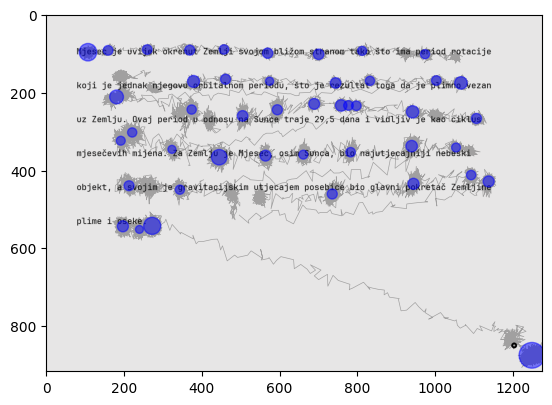

In [10]:
import math

import matplotlib.pyplot as plt
import PIL.Image
import polars as pl
from matplotlib.patches import Circle

trial = 0
screen = "page_2"

gaze_df = dataset.gaze[trial].frame.select(
    pl.col("screen"),
    pl.col("pixel").list.get(0).alias("pixel_x"),
    pl.col("pixel").list.get(1).alias("pixel_y"),
).filter(pl.col("screen") == screen)

event_df = (
    dataset.events[trial]
    .frame.filter(pl.col("name") == "fixation")
    .select(
        pl.col("screen"),
        pl.col("duration"),
        pl.col("location").list.get(0).alias("pixel_x"),
        pl.col("location").list.get(1).alias("pixel_y"),
    )
    .filter(pl.col("screen") == screen)
)

fig, ax = plt.subplots()
stimulus_image = PIL.Image.open(
    f"../data/stimuli_MultiplEYE_HR_CH_Zurich_1_2025/stimuli_images_hr_ch_1/enc_wikimoon_id13_{screen}_hr.png"
)
ax.imshow(stimulus_image)
plt.plot(gaze_df["pixel_x"], gaze_df["pixel_y"], color="black", linewidth=0.5, alpha=0.3)
for row in event_df.iter_rows(named=True):
    fixation = Circle(
        (row["pixel_x"], row["pixel_y"]),
        math.sqrt(row["duration"]),
        color="blue",
        fill=True,
        alpha=0.5,
        zorder=10,
    )
    ax.add_patch(fixation)
ax.set_xlim((0, experiment.screen.width_px))
ax.set_ylim((experiment.screen.height_px, 0))